In [2]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from datetime import datetime as dt
import re
from matplotlib import pyplot as plt
import matplotlib
import fastText
import html
import string
import nltk
from multiprocessing import Process
import multiprocessing
import time
import sys
from importlib import reload
import redis
# from urllib import request
from urllib.parse import urlparse
import requests as req
# from lxml import html
import logging
# from scrapy.http import Request
import requests
import json
import requests
from scrapy.http import TextResponse
from bs4 import BeautifulSoup
import re
from collections import Counter
from sklearn.metrics import precision_recall_curve
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import pandas as pd
import math
import mpld3
import pickle

mpld3.enable_notebook()
%matplotlib inline

In [4]:
import utils
utils = reload(utils)

In [5]:
df_comparisons = pd.read_csv('df_comparisons_unsup.csv', index_col=0)

In [6]:
df_news = pd.read_csv('df_news_unsup.csv', parse_dates=['Datetime', 'Date'])

In [7]:
fields = ['title', 'spot','text']

In [8]:
for field in fields:
    df_news[field+'_pp_str'].fillna('', inplace=True)
    df_news[field+'_pp'] = df_news[field+'_pp_str'].apply(lambda x: x.split())

In [9]:
for index, row in df_comparisons.iterrows():
    
    row_1 = df_news.iloc[int(row.ind0)]
    row_2 = df_news.iloc[int(row.ind1)]
    
    # Datetime difference features
    dt_1 = row_1.Datetime
    dt_2 = row_2.Datetime
    d_1 = row_1.Date
    d_2 = row_2.Date
    diff = dt_1 - dt_2
    diff_days = abs(diff.days)
    diff_hours = abs(diff.total_seconds() / 3600)
    df_comparisons.loc[index, 'diff_days'] = diff_days
    df_comparisons.loc[index, 'diff_hours'] = diff_hours
    
    # Length features
    for field in ['text','title','spot']:
        
        len1 = len(row_1[field+'_pp'])
        len2 = len(row_2[field+'_pp'])
        
        df_comparisons.loc[index, 'len_'+field+'_min'] = min(len1, len2)
        df_comparisons.loc[index, 'len_'+field+'_max'] = max(len1, len2)
        df_comparisons.loc[index, 'len_'+field+'_diff'] = abs(len1 - len2)
        
        if max(len1, len2) == 0:
            diff_perc = -1
            max_o_min = -1
        else:
            diff_perc = abs(len1 - len2) / max(len1, len2)
            
            if min(len1, len2) == 0:
                max_o_min = 100
            else:
                max_o_min = max(len1, len2) / min(len1, len2)
                
        df_comparisons.loc[index, 'len_'+field+'_diff_perc'] = diff_perc
        df_comparisons.loc[index, 'len_'+field+'_max_o_min'] = max_o_min

In [10]:
df_comparisons_bu = df_comparisons.copy()

In [11]:
df_comparisons = df_comparisons_bu.copy()

In [12]:
for field in fields:
    
    colnow = 'len_' + field + '_diff_perc'
    indsnow = df_comparisons[colnow] == -1
    df_comparisons.loc[indsnow,colnow] = 0
    
    colnow = 'len_' + field + '_max_o_min'
    indsnow = df_comparisons[colnow] == -1
    df_comparisons.loc[indsnow,colnow] = 1
    
    indsnow = df_comparisons[colnow] == 100
    maxnow = df_comparisons[~indsnow][colnow].max()
    df_comparisons.loc[indsnow,colnow] = maxnow

In [13]:
df_comparisons.diff_days.fillna(df_comparisons.diff_days.mean(), inplace=True)
df_comparisons.diff_hours.fillna(df_comparisons.diff_hours.mean(), inplace=True)

In [45]:
methods = ['ju', 'js','jc', 'ft', 'wv']
methods_cross = [met + '_' + field for met in methods for field in fields]
methods_cross_norm = [met+'_norm' for met in methods_cross]

features = ['min', 'max', 'diff', 'diff_perc', 'max_o_min']
columns_sup = ['len_' + field + '_' + feat for field in fields for feat in features] + ['diff_days', 'diff_hours']

columns_all = methods_cross_norm + columns_sup + ['comb'] 

In [46]:
def print_prec_recall(colnames, return_res=False, dfnow=None):
    
    if dfnow is None:
        dfnow = df_comparisons
        
    if not isinstance(colnames, list):
        colnames = [colnames]
    
    table = []
    res = {}
    for colname in colnames:
    
        predictions = dfnow[colname]
        labels = dfnow['label']

        acc = float((predictions == labels).sum() / len(predictions))

        true_positive = float(np.logical_and(predictions==1, labels==1).sum())
        true_negative = float(np.logical_and(predictions==0, labels==0).sum())
        false_positive = float(np.logical_and(predictions==1, labels==0).sum())
        false_negative = float(np.logical_and(predictions==0, labels==1).sum())

        if predictions.sum() == 0 or predictions.sum() == predictions.shape[0]:
            print("Warning! number of positive predictions: %i" % predictions.sum())
            precision = 0 
            recall = 0
            f1 = 0
        else:
            precision = float(true_positive / (true_positive + false_positive))
            recall = float(true_positive / (true_positive + false_negative))
            f1 = 2*(recall * precision) / (recall + precision)
    
        table.append([colname, acc, f1, precision, recall, true_positive, true_negative, false_positive, false_negative])
        
        res[colname] = dict(
            acc = acc,
            f1 = f1,
            precision = precision,
            recall = recall,
            true_positive = true_positive,
            true_negative = true_negative,
            false_positive = false_positive,
            false_negative = false_negative)

    print(tabulate(table, headers=['METHOD', 'ACC', 'F1', 'PREC', 'RECALL', 'TP', 'TN', 'FP', 'FN'], tablefmt="fancy_grid"))
    
    if return_res:
        return res

__Normalize all features to [0,1]__

In [47]:
norm_params = dict(
    ju_title_norm = [-1, 6],
    ju_spot_norm = [-0.5, 5],
    ju_text_norm = [-0.5, 4.9],
    js_title_norm = [-4, 2.5],
    js_spot_norm = [-4.5, 3],
    js_text_norm = [-1.3, 3.2],
    jc_title_norm = [-0.6, 6],
    jc_spot_norm = [-0.6, 5],
    jc_text_norm = [-0.5, 4.9],
    ft_title_norm = [-1.5, 0.7],
    ft_spot_norm = [-2, 0.6],
    ft_text_norm = [-4, 0.8],
    wv_title_norm = [-4, 1.7],
    wv_spot_norm = [-4, 1.1],
    wv_text_norm = [-4, 0.8],
    len_title_min = [1, 12],
    len_title_max = [1, 19],
    len_title_diff = [0, 18],
    len_title_diff_perc = [0, 1],
    len_title_max_o_min = [1, 14],
    len_spot_min = [0, 80],
    len_spot_max = [0, 100],
    len_spot_diff = [0, 100],
    len_spot_diff_perc = [0, 1],
    len_spot_max_o_min = [1, 100],
    len_text_min = [0, 1000],
    len_text_max = [30, 2500],
    len_text_diff = [0, 2500],
    len_text_diff_perc = [0, 1],
    len_text_max_o_min = [1, 100],
    comb = [-2.5, 3.5],
    comb02 = [-0.7, 5],
    comb03 = [-4, 1],
    diff_days = [0,40],
    diff_hours=[0, 1200]
)

In [49]:
len(columns_all)

33

In [50]:
for colname in columns_all:
    minnow, maxnow = norm_params[colname]
    df_comparisons[colname+'_snorm'] = (df_comparisons[colname] - minnow ) / maxnow

In [51]:
columns_all_snorm = [colname+'_snorm' for colname in columns_all]

__Split validations__

In [52]:
n_val_splits = 10

dfs_val_comparisons = utils.split_val_parts(df_comparisons, n_val_splits)

0
(1672, 94)
label
0.0    1478
1.0     194
Name: label, dtype: int64

1
(1669, 94)
label
0.0    1490
1.0     179
Name: label, dtype: int64

2
(1687, 94)
label
0.0    1515
1.0     172
Name: label, dtype: int64

3
(1666, 94)
label
0.0    1483
1.0     183
Name: label, dtype: int64

4
(1666, 94)
label
0.0    1470
1.0     196
Name: label, dtype: int64

5
(1690, 94)
label
0.0    1497
1.0     193
Name: label, dtype: int64

6
(1751, 94)
label
0.0    1566
1.0     185
Name: label, dtype: int64

7
(1784, 94)
label
0.0    1583
1.0     201
Name: label, dtype: int64

8
(1661, 94)
label
0.0    1482
1.0     179
Name: label, dtype: int64

9
(1612, 94)
label
0.0    1436
1.0     176
Name: label, dtype: int64



In [53]:
columns_all_snorm

['ju_title_norm_snorm',
 'ju_spot_norm_snorm',
 'ju_text_norm_snorm',
 'js_title_norm_snorm',
 'js_spot_norm_snorm',
 'js_text_norm_snorm',
 'jc_title_norm_snorm',
 'jc_spot_norm_snorm',
 'jc_text_norm_snorm',
 'ft_title_norm_snorm',
 'ft_spot_norm_snorm',
 'ft_text_norm_snorm',
 'wv_title_norm_snorm',
 'wv_spot_norm_snorm',
 'wv_text_norm_snorm',
 'len_title_min_snorm',
 'len_title_max_snorm',
 'len_title_diff_snorm',
 'len_title_diff_perc_snorm',
 'len_title_max_o_min_snorm',
 'len_spot_min_snorm',
 'len_spot_max_snorm',
 'len_spot_diff_snorm',
 'len_spot_diff_perc_snorm',
 'len_spot_max_o_min_snorm',
 'len_text_min_snorm',
 'len_text_max_snorm',
 'len_text_diff_snorm',
 'len_text_diff_perc_snorm',
 'len_text_max_o_min_snorm',
 'diff_days_snorm',
 'diff_hours_snorm',
 'comb_snorm']

__Decision Tree__

In [55]:
colname = 'dt'
classifier_func = lambda: DecisionTreeClassifier(max_depth=None, criterion='entropy', min_samples_leaf=10)
trees, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)

print_prec_recall('dt')

__Random Forest__

In [56]:
colname = 'rf'
classifier_func = lambda: RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None)
rfs, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)

In [57]:
print_prec_recall('rf')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ rf       │ 0.997627 │ 0.989236 │ 0.989236 │ 0.989236 │ 1838 │ 14980 │   20 │   20 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__MLP__

In [58]:
colname = 'mlp'
classifier_func = lambda: MLPClassifier(hidden_layer_sizes=(500,500), activation='relu', solver='adam', alpha=0.00001, batch_size=100, learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, verbose=True)

mlps, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)

Iteration 1, loss = 0.18271248
Iteration 2, loss = 0.03412051
Iteration 3, loss = 0.02083362
Iteration 4, loss = 0.01593665
Iteration 5, loss = 0.01301535
Iteration 6, loss = 0.01143980
Iteration 7, loss = 0.01046403
Iteration 8, loss = 0.00980589
Iteration 9, loss = 0.00875878
Iteration 10, loss = 0.00839338
Iteration 11, loss = 0.00806896
Iteration 12, loss = 0.00806123
Iteration 13, loss = 0.00781654
Iteration 14, loss = 0.00734272
Iteration 15, loss = 0.00704730
Iteration 16, loss = 0.00682917
Iteration 17, loss = 0.00688365
Iteration 18, loss = 0.00653356
Iteration 19, loss = 0.00659759
Iteration 20, loss = 0.00637921
Iteration 21, loss = 0.00634581
Iteration 22, loss = 0.00626879
Iteration 23, loss = 0.00601960
Iteration 24, loss = 0.00596349
Iteration 25, loss = 0.00617894
Iteration 26, loss = 0.00571825
Iteration 27, loss = 0.00617680
Iteration 28, loss = 0.00532128
Iteration 29, loss = 0.00573483
Iteration 30, loss = 0.00535746
Iteration 31, loss = 0.00549826
Iteration 32, los

In [59]:
print_prec_recall('mlp')

╒══════════╤═════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │     ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪═════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mlp      │ 0.99822 │ 0.991927 │ 0.991927 │ 0.991927 │ 1843 │ 14985 │   15 │   15 │
╘══════════╧═════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [117]:
colname = 'mlp'
classifier_func = lambda: MLPClassifier(hidden_layer_sizes=(500,500), activation='relu', solver='adam', alpha=0.00001, batch_size=100, learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, verbose=True)

mlps, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)

Iteration 1, loss = 0.28066141
Iteration 2, loss = 0.06457892
Iteration 3, loss = 0.03254234
Iteration 4, loss = 0.02133416
Iteration 5, loss = 0.01642850
Iteration 6, loss = 0.01375831
Iteration 7, loss = 0.01249466
Iteration 8, loss = 0.01141594
Iteration 9, loss = 0.01071990
Iteration 10, loss = 0.01043972
Iteration 11, loss = 0.00991410
Iteration 12, loss = 0.00967410
Iteration 13, loss = 0.00996251
Iteration 14, loss = 0.00960363
Iteration 15, loss = 0.00888817
Iteration 16, loss = 0.00889678
Iteration 17, loss = 0.00863993
Iteration 18, loss = 0.00887777
Iteration 19, loss = 0.00863747
Iteration 20, loss = 0.00927467
Iteration 21, loss = 0.00888679
Iteration 22, loss = 0.00852221
Iteration 23, loss = 0.00854013
Iteration 24, loss = 0.00810281
Iteration 25, loss = 0.00864055
Iteration 26, loss = 0.00820343
Iteration 27, loss = 0.00828366
Iteration 28, loss = 0.00768176
Iteration 29, loss = 0.00833697
Iteration 30, loss = 0.00859424
Iteration 31, loss = 0.00752017
Iteration 32, los

In [118]:
print_prec_recall('mlp')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mlp      │ 0.997212 │ 0.987362 │ 0.986566 │ 0.988159 │ 1836 │ 14975 │   25 │   22 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__SVM__

Grid search for SVM on one split

In [109]:
split_inds = [ii for ii in range(n_val_splits)]
split_inds.remove(0)
df_train_now = pd.concat([dfs_val_comparisons[ii] for ii in split_inds], axis=0).copy()
df_test_now = dfs_val_comparisons[0].copy()

Xtrain = df_train_now[columns_all_snorm].values
ytrain = df_train_now['label'].values
Xtest = df_test_now[columns_all_snorm].values
ytest = df_test_now['label'].values

In [110]:
gs = [1e-7, 1e-5, 1e-3, 1e-1, 1, 10]
cs = [1, 10, 100, 1000, 10000, 100000]

# df_svm_crossval = df_comparisons.copy()

n_gs = len(gs)
n_cs = len(cs)

cv_precs = np.zeros((n_gs, n_cs))
cv_recalls = np.zeros((n_gs, n_cs))
cv_f1s = np.zeros((n_gs, n_cs))

for ind_g in range(n_gs):
    gnow = float(gs[ind_g])
    for ind_c in range(n_cs):
        cnow = cs[ind_c]
        
        colname = 'svm_g_' + str(ind_g) + '_c_' + str(ind_c)
        classifier_func = lambda: SVC(C=cnow, kernel='rbf', gamma=gnow)
        
        model = classifier_func()
        model = model.fit(Xtrain, ytrain)
        
        yhat = model.predict(Xtest)
        df_test_now.loc[df_test_now.index, colname] = yhat
        print('c=%f, g=%e' % (cnow, gnow))
        resnow = print_prec_recall(colname, return_res=True, dfnow=df_test_now)
        
        cv_precs[ind_g, ind_c] = resnow[colname]['precision']
        cv_recalls[ind_g, ind_c] = resnow[colname]['recall']
        cv_f1s[ind_g, ind_c] = resnow[colname]['f1']

c=1.000000, g=1.000000e-07
Warning! number of positive predictions: 0
╒═════════════╤══════════╤══════╤════════╤══════════╤══════╤══════╤══════╤══════╕
│ METHOD      │      ACC │   F1 │   PREC │   RECALL │   TP │   TN │   FP │   FN │
╞═════════════╪══════════╪══════╪════════╪══════════╪══════╪══════╪══════╪══════╡
│ svm_g_0_c_0 │ 0.886053 │    0 │      0 │        0 │    0 │ 1493 │    0 │  192 │
╘═════════════╧══════════╧══════╧════════╧══════════╧══════╧══════╧══════╧══════╛
c=10.000000, g=1.000000e-07
Warning! number of positive predictions: 0
╒═════════════╤══════════╤══════╤════════╤══════════╤══════╤══════╤══════╤══════╕
│ METHOD      │      ACC │   F1 │   PREC │   RECALL │   TP │   TN │   FP │   FN │
╞═════════════╪══════════╪══════╪════════╪══════════╪══════╪══════╪══════╪══════╡
│ svm_g_0_c_1 │ 0.886053 │    0 │      0 │        0 │    0 │ 1493 │    0 │  192 │
╘═════════════╧══════════╧══════╧════════╧══════════╧══════╧══════╧══════╧══════╛
c=100.000000, g=1.000000e-07
Warning! n

In [111]:
print(cv_f1s)

[[0.         0.         0.         0.87790698 0.95675676 0.984375  ]
 [0.         0.87790698 0.95675676 0.984375   0.98963731 0.98963731]
 [0.97066667 0.98701299 0.98701299 0.98445596 0.98445596 0.984375  ]
 [0.98701299 0.98701299 0.984375   0.984375   0.97905759 0.97905759]
 [0.98701299 0.98701299 0.98701299 0.98701299 0.98701299 0.98701299]
 [0.62857143 0.70707071 0.70707071 0.70707071 0.70707071 0.70707071]]


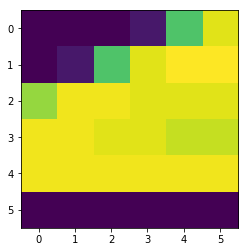

In [114]:
fig, ax1 = plt.subplots(1,1)
tmp = cv_f1s.copy()
tmp[0,:3] = 0.87
tmp[1,0] = 0.87
tmp[-1,:] = 0.87
ax1.imshow(tmp);
# ax1.set_xticklabels(cs)

Train svm

In [61]:
colname = 'svm'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)
print_prec_recall('svm')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm      │ 0.997983 │ 0.990845 │ 0.991379 │ 0.990312 │ 1840 │ 14984 │   16 │   18 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [96]:
colname = 'svm'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)
print_prec_recall('svm')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm      │ 0.997449 │ 0.988438 │ 0.987641 │ 0.989236 │ 1838 │ 14977 │   23 │   20 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [115]:
colname = 'svm'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm, n_val_splits)
print_prec_recall('svm')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm      │ 0.997627 │ 0.989218 │ 0.990821 │ 0.987621 │ 1835 │ 14983 │   17 │   23 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__Majority Voting__

In [62]:
df_comparisons['mv'] =  df_comparisons[['mlp','rf','svm']].mode(axis=1)
print_prec_recall('mv')

╒══════════╤═════════╤═════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │     ACC │      F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪═════════╪═════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mv       │ 0.99828 │ 0.99219 │ 0.992992 │ 0.991389 │ 1842 │ 14987 │   13 │   16 │
╘══════════╧═════════╧═════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [99]:
df_comparisons['mv'] =  df_comparisons[['mlp','rf','svm']].mode(axis=1)
print_prec_recall('mv')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mv       │ 0.997924 │ 0.990584 │ 0.990317 │  0.99085 │ 1841 │ 14982 │   18 │   17 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__Score averaging combination__

In [63]:
thr_comb = -0.0363691467748684
df_comparisons['comb_class'] = df_comparisons['comb'] >= thr_comb
print_prec_recall('comb_class')

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.996322 │ 0.983315 │ 0.983315 │ 0.983315 │ 1827 │ 14969 │   31 │   31 │
╘════════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [100]:
thr_comb = -0.0675493
df_comparisons['comb_class'] = df_comparisons['comb'] >= thr_comb
print_prec_recall('comb_class')

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.995729 │ 0.980624 │ 0.980624 │ 0.980624 │ 1822 │ 14964 │   36 │   36 │
╘════════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [121]:
thr_comb = -0.0200133
df_comparisons['comb_class'] = df_comparisons['comb'] >= thr_comb
print_prec_recall('comb_class')

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.996204 │ 0.982777 │ 0.982777 │ 0.982777 │ 1826 │ 14968 │   32 │   32 │
╘════════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


__ALL RESULTS__

In [64]:
results = print_prec_recall(['comb_class', 'mlp', 'rf', 'svm', 'mv'], return_res=True)

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.996322 │ 0.983315 │ 0.983315 │ 0.983315 │ 1827 │ 14969 │   31 │   31 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mlp        │ 0.99822  │ 0.991927 │ 0.991927 │ 0.991927 │ 1843 │ 14985 │   15 │   15 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ rf         │ 0.997627 │ 0.989236 │ 0.989236 │ 0.989236 │ 1838 │ 14980 │   20 │   20 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ svm        │ 0.997983 │ 0.990845 │ 0.991379 │ 0.990312 │ 1840 │ 14984 │   16 │   18 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mv         │ 0.99828  │ 0.9921

In [101]:
results = print_prec_recall(['comb_class', 'mlp', 'rf', 'svm', 'mv'], return_res=True)

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.995729 │ 0.980624 │ 0.980624 │ 0.980624 │ 1822 │ 14964 │   36 │   36 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mlp        │ 0.997509 │ 0.988698 │ 0.988698 │ 0.988698 │ 1837 │ 14979 │   21 │   21 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ rf         │ 0.997509 │ 0.988698 │ 0.988698 │ 0.988698 │ 1837 │ 14979 │   21 │   21 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ svm        │ 0.997449 │ 0.988438 │ 0.987641 │ 0.989236 │ 1838 │ 14977 │   23 │   20 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mv         │ 0.997924 │ 0.9905

In [65]:
with open('supervised_results.pickle', 'wb') as f:
    pickle.dump(results, f)

__Only embedding distances as features__

In [70]:
methods_we = ['ft', 'wv']
methods_cross_we = [met + '_' + field for met in methods_we for field in fields]
methods_cross_norm_we = [met+'_norm' for met in methods_cross_we]

columns_all_we = methods_cross_norm_we + columns_sup + ['comb'] 
columns_all_snorm_we = [colnow + '_snorm' for colnow in columns_all_we]

In [72]:
colname = 'dt_we'
classifier_func = lambda: DecisionTreeClassifier(max_depth=None, criterion='entropy', min_samples_leaf=10)
trees_we, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)

print_prec_recall('dt_we')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ dt_we    │ 0.996322 │ 0.983324 │ 0.982796 │ 0.983854 │ 1828 │ 14968 │   32 │   30 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [73]:
colname = 'rf_we'
classifier_func = lambda: RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None)
rfs_we, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)
print_prec_recall('rf_we')

╒══════════╤══════════╤═════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │      F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪═════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ rf_we    │ 0.997331 │ 0.98788 │ 0.988679 │ 0.987083 │ 1834 │ 14979 │   21 │   24 │
╘══════════╧══════════╧═════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [74]:
colname = 'svm_we'
classifier_func = lambda: SVC(C=1000000, kernel='rbf', gamma=1e-5)
svms, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)
print_prec_recall('svm_we')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ svm_we   │ 0.998161 │ 0.991642 │ 0.993517 │ 0.989774 │ 1839 │ 14988 │   12 │   19 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [75]:
colname = 'mlp_we'
classifier_func = lambda: MLPClassifier(hidden_layer_sizes=(500,500), activation='relu', solver='adam', alpha=0.00001, batch_size=100, learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, verbose=True)

mlps_we, df_comparisons = utils.cross_validate(dfs_val_comparisons, df_comparisons, classifier_func, colname, columns_all_snorm_we, n_val_splits)

Iteration 1, loss = 0.17532935
Iteration 2, loss = 0.05085636
Iteration 3, loss = 0.03589856
Iteration 4, loss = 0.02961328
Iteration 5, loss = 0.02594138
Iteration 6, loss = 0.02349748
Iteration 7, loss = 0.02198571
Iteration 8, loss = 0.02101104
Iteration 9, loss = 0.01999014
Iteration 10, loss = 0.01895475
Iteration 11, loss = 0.01842179
Iteration 12, loss = 0.01850106
Iteration 13, loss = 0.01721702
Iteration 14, loss = 0.01725315
Iteration 15, loss = 0.01621577
Iteration 16, loss = 0.01565411
Iteration 17, loss = 0.01581414
Iteration 18, loss = 0.01523830
Iteration 19, loss = 0.01421697
Iteration 20, loss = 0.01434182
Iteration 21, loss = 0.01352974
Iteration 22, loss = 0.01362050
Iteration 23, loss = 0.01290705
Iteration 24, loss = 0.01270528
Iteration 25, loss = 0.01203604
Iteration 26, loss = 0.01259446
Iteration 27, loss = 0.01161900
Iteration 28, loss = 0.01159851
Iteration 29, loss = 0.01173404
Iteration 30, loss = 0.01110864
Iteration 31, loss = 0.01136701
Iteration 32, los

In [76]:
print_prec_recall('mlp_we')

╒══════════╤══════════╤══════════╤═════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │    PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪═════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mlp_we   │ 0.997271 │ 0.987588 │ 0.99026 │  0.98493 │ 1830 │ 14982 │   18 │   28 │
╘══════════╧══════════╧══════════╧═════════╧══════════╧══════╧═══════╧══════╧══════╛


In [77]:
df_comparisons['mv_we'] =  df_comparisons[['mlp_we','rf_we','svm_we']].mode(axis=1)
print_prec_recall('mv_we')

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD   │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ mv_we    │ 0.997924 │ 0.990558 │ 0.992969 │ 0.988159 │ 1836 │ 14987 │   13 │   22 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════╧═══════╧══════╧══════╛


In [79]:
results = print_prec_recall(['comb_class', 'mlp', 'rf', 'svm', 'mv', 'mlp_we', 'rf_we','svm_we', 'mv_we'], return_res=True)

╒════════════╤══════════╤══════════╤══════════╤══════════╤══════╤═══════╤══════╤══════╕
│ METHOD     │      ACC │       F1 │     PREC │   RECALL │   TP │    TN │   FP │   FN │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════╪═══════╪══════╪══════╡
│ comb_class │ 0.996322 │ 0.983315 │ 0.983315 │ 0.983315 │ 1827 │ 14969 │   31 │   31 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mlp        │ 0.99822  │ 0.991927 │ 0.991927 │ 0.991927 │ 1843 │ 14985 │   15 │   15 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ rf         │ 0.997627 │ 0.989236 │ 0.989236 │ 0.989236 │ 1838 │ 14980 │   20 │   20 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ svm        │ 0.997983 │ 0.990845 │ 0.991379 │ 0.990312 │ 1840 │ 14984 │   16 │   18 │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────┼───────┼──────┼──────┤
│ mv         │ 0.99828  │ 0.9921

In [81]:
with open('supervised_results.pickle', 'wb') as f:
    pickle.dump(results, f)

In [149]:
header = ' & '.join(['\\textbf{'+key+'}' for key in ['Method', 'F1', 'Prec.', 'Recall', 'Acc.']]) + '\\\\'
met2full = {'comb_class': "Unsup. Comb.", 'mlp': 'MLP', 'rf': 'RF', 'svm': 'SVM', 'mv': 'Maj. Vot.'}
colsnow = ['f1', 'precision', 'recall', 'acc']

print(header)

for met in ['comb_class', 'mlp', 'rf', 'svm', 'mv']:
    res = results[met]
    print(' & '.join([met2full[met]] + ["%.4f" % (res[col]) for col in colsnow]) + '\\\\')
    

\textbf{Method} & \textbf{F1} & \textbf{Prec.} & \textbf{Recall} & \textbf{Acc.}\\
Unsup. Comb. & 0.9828 & 0.9828 & 0.9828 & 0.9962\\
MLP & 0.9838 & 0.9844 & 0.9833 & 0.9964\\
RF & 0.9855 & 0.9839 & 0.9871 & 0.9968\\
SVM & 0.9865 & 0.9881 & 0.9849 & 0.9970\\
Maj. Vot. & 0.9884 & 0.9887 & 0.9882 & 0.9974\\


In [150]:
with open('unsupervised_results.pickle', 'rb') as f:
    results_un = pickle.load(f)

In [153]:
results_un.keys()

dict_keys(['ju_text', 'ju_title', 'ju_spot', 'js_text', 'js_title', 'js_spot', 'jc_text', 'jc_title', 'jc_spot', 'ft_text', 'ft_title', 'ft_spot', 'ju_text_norm', 'ju_title_norm', 'ju_spot_norm', 'js_text_norm', 'js_title_norm', 'js_spot_norm', 'jc_text_norm', 'jc_title_norm', 'jc_spot_norm', 'ft_text_norm', 'ft_title_norm', 'ft_spot_norm', 'comb'])

In [164]:
methods = ['ju','js','jc','ft']
fields = ['title','spot', 'text']
methods_cross = [met + '_' + field for met in methods for field in fields]
methods_cross_norm = [met+'_norm' for met in methods_cross]

In [165]:
header = ' & '.join(['\\textbf{'+key+'}' for key in ['Method', 'F1', 'Prec.', 'Recall']]) + '\\\\'
colsnow = ['f1', 'precision', 'recall']

met2name = {'f1': 'F1', 'precision': 'Precision', 'recall': 'Recall'}


print(header)

for met in methods:
    
    elsnow = ['\\multirow{3}{*}{'+met.upper()+'}']
    
    for field in fields:
        
        elsnow.append(field)
        for colnow in colsnow:
            elsnow.append("%.4f" % (results_un[met+'_'+field][colnow]))
            
        print(' & '.join(elsnow) + '\\\\')
        
        elsnow = ['']
    print('\\hline')
        


\textbf{Method} & \textbf{F1} & \textbf{Prec.} & \textbf{Recall}\\
\multirow{3}{*}{JU} & title & 0.8149 & 0.8090 & 0.8208\\
 & spot & 0.9369 & 0.9384 & 0.9354\\
 & text & 0.9639 & 0.9639 & 0.9639\\
\hline
\multirow{3}{*}{JS} & title & 0.8120 & 0.8070 & 0.8170\\
 & spot & 0.9408 & 0.9413 & 0.9403\\
 & text & 0.9553 & 0.9553 & 0.9553\\
\hline
\multirow{3}{*}{JC} & title & 0.8149 & 0.8090 & 0.8208\\
 & spot & 0.9369 & 0.9384 & 0.9354\\
 & text & 0.9639 & 0.9639 & 0.9639\\
\hline
\multirow{3}{*}{FT} & title & 0.8208 & 0.8208 & 0.8208\\
 & spot & 0.9071 & 0.9074 & 0.9069\\
 & text & 0.9214 & 0.9214 & 0.9214\\
\hline


In [168]:
print(' & '.join(["%.4f" % results_un['comb'][col] for col in colsnow]))

0.9828 & 0.9828 & 0.9828
